In [1]:
%load_ext autoreload
%autoreload 2

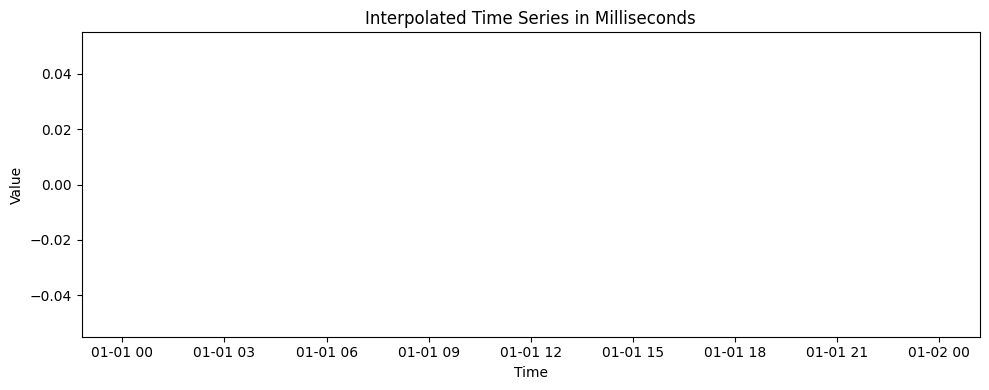

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample DataFrame with UNIX timestamps in microseconds and some value
data = {
    'timestamp': [1_600_000_000_000_000, 1_600_000_000_100_000, 1_600_000_000_300_000],
    'value': [10, 20, 15]
}
df = pd.read_csv('processed_signals/009.csv')
df = df[['timestamp', 'bvp', 'systolic_peak', 'temperature']]     # keep only columns of interests
#df = pd.DataFrame(data)

# Convert microseconds to datetime (pandas expects nanoseconds, so multiply by 1,000)
df['timestamp'] = pd.to_datetime(df['timestamp']*1e3)-np.timedelta64(4, 'h')

# Set timestamp as index
df.set_index('timestamp', inplace=True)
#df=df[10000:30000]
# Optional: Resample/interpolate data to a regular interval (e.g., every millisecond)
df_resampled = df.resample('1ms').interpolate('linear')  # or 'time', 'polynomial', etc.

# Plot using seaborn or matplotlib
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_resampled, x=df_resampled.index, y='bvp')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Interpolated Time Series in Milliseconds')
plt.tight_layout()
plt.show()


,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,eda,temperature,bvp,systolic_peak,steps
timestamp,,,,,,,,,,,
2025-03-12 11:09:50,-0.345193,-0.011361,0.907020,NaN,NaN,NaN,-0.030401,NaN,0.005101,1.0,NaN
2025-03-12 11:09:51,-0.146446,-0.035736,1.001854,NaN,NaN,NaN,-0.030171,28.531250,0.042650,1.0,NaN
2025-03-12 11:09:52,-0.152771,-0.075790,0.994881,NaN,NaN,NaN,-0.031061,28.523438,-0.051856,1.0,NaN
2025-03-12 11:09:53,-0.084503,-0.163017,0.988579,NaN,NaN,NaN,-0.030835,28.523438,0.747303,1.0,NaN
2025-03-12 11:09:54,0.345764,-0.051682,0.881065,NaN,NaN,NaN,-0.030745,28.554688,-1.702334,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12 12:49:17,-0.019440,-0.284233,-0.954926,NaN,NaN,NaN,-0.030630,28.796875,0.078149,1.0,8.0
2025-03-12 12:49:18,-0.035239,-0.167413,-0.986877,NaN,NaN,NaN,-0.029978,28.757812,0.250200,1.0,8.0
2025-03-12 12:49:19,-0.029419,-0.138565,-0.988266,NaN,NaN,NaN,-0.030509,28.750000,0.277521,1.0,8.0


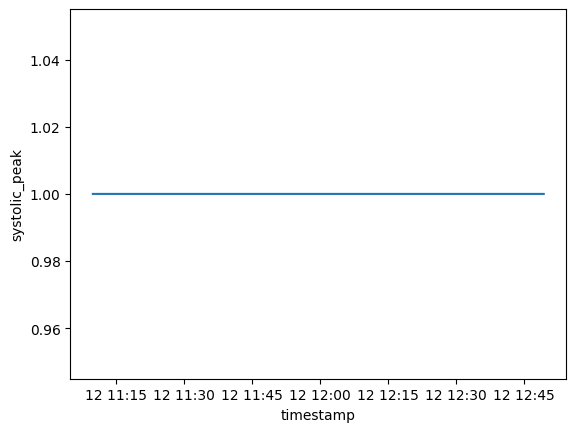

In [60]:
df = pd.read_csv('processed_signals/006.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']*1e3)-np.timedelta64(4, 'h')
#df['timestamp'] = df['timestamp'].dt.floor('ms')
df.set_index('timestamp', inplace=True)
df_resampled = df[:].resample('1s').mean().interpolate('linear')
sns.lineplot(data=df_resampled, x=df_resampled.index, y='systolic_peak')
df_resampled

<Axes: xlabel='timestamp', ylabel='systolic_peak'>

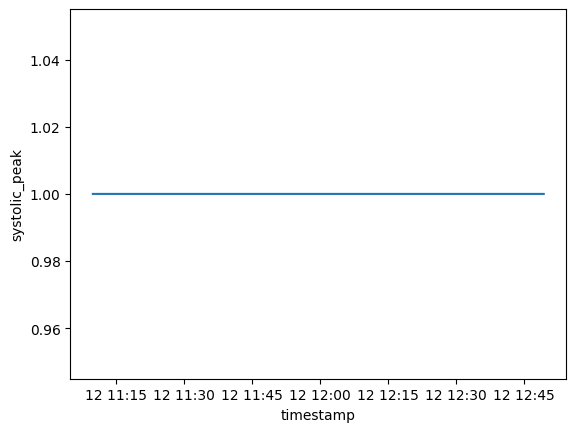

In [62]:
sns.lineplot(data=df, x=df.index, y='systolic_peak')

In [2]:
import cv2  # Video processing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import pandas as pd

In [5]:
def stack_videos(rgb, depth, thermal):
    # Apply colormaps to depth/thermal
    depth_colored = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
    thermal_colored = cv2.applyColorMap(thermal, cv2.COLORMAP_HOT)
    
    # Resize and concatenate
    top_row = np.hstack([rgb, depth_colored])
    bottom_row = np.hstack([thermal_colored, np.zeros_like(rgb)])
    return np.vstack([top_row, bottom_row])

def update_signals_plot(timestamp, signals, window_sec=5):
    fig, ax = plt.subplots(figsize=(8, 3))
    start_time = timestamp - window_sec
    
    for signal in signals:
        mask = (signal["timestamps"] >= start_time) & (signal["timestamps"] <= timestamp)
        ax.plot(signal["timestamps"][mask], signal["data"][mask])
    
    ax.set_xlim(start_time, timestamp)
    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return img

In [18]:
def create_visualization(video_paths, signals_df, output_path='output.mp4', signal_window_sec=5):
    # Initialize video readers
    caps = [cv2.VideoCapture(p) for p in video_paths]
    
    # Get maximum dimensions across all videos
    max_width = max(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) for cap in caps)
    max_height = max(int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) for cap in caps)
    fps = int(caps[0].get(cv2.CAP_PROP_FPS))
    
    # Target size for each video cell (preserve aspect ratio)
    grid_cols = 2
    grid_rows = 2
    target_width = max_width // grid_cols
    target_height = max_height // grid_rows

    # Video writer setup
    final_width = target_width * grid_cols
    final_height = target_height * grid_rows + 400  # + plot height
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (final_width, final_height))
    
    # Convert UNIX timestamps to relative seconds
    signals_df = signals_df.copy()
    signals_df['rel_time'] = (signals_df['timestamp'] - signals_df['timestamp'].min()) / 1e9
    
    def resize_with_aspect_ratio(frame, target_w, target_h):
        """Resize frame with aspect ratio preserved using letterboxing"""
        h, w = frame.shape[:2]
        scale = min(target_w/w, target_h/h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(frame, (new_w, new_h))
        
        # Add black borders
        delta_w = target_w - new_w
        delta_h = target_h - new_h
        top, bottom = delta_h//2, delta_h - delta_h//2
        left, right = delta_w//2, delta_w - delta_w//2
        return cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                cv2.BORDER_CONSTANT, value=(0,0,0))

    # Video processing loop
    frame_count = 0
    while caps[0].isOpened():
        grid_frames = []
        rets = []
        
        # Read and process all frames
        for cap in caps:
            ret, frame = cap.read()
            rets.append(ret)
            if ret:
                # Resize with aspect ratio preservation
                processed = resize_with_aspect_ratio(frame, target_width, target_height)
                grid_frames.append(processed)
            else:
                # Create black frame if stream ends
                grid_frames.append(np.zeros((target_height, target_width, 3), dtype=np.uint8))
        
        if not all(rets):
            break
            
        # Arrange in grid with black background
        grid = np.zeros((target_height*grid_rows, target_width*grid_cols, 3), dtype=np.uint8)
        
        # Position frames in grid
        for i, frame in enumerate(grid_frames):
            row = i // grid_cols
            col = i % grid_cols
            y_start = row * target_height
            x_start = col * target_width
            grid[y_start:y_start+target_height, x_start:x_start+target_width] = frame
        
        # Create signals plot
        current_time = frame_count / fps
        start_time = max(0, current_time - signal_window_sec)
        
        fig, ax = plt.subplots(figsize=(10, 4))
        mask = (signals_df['rel_time'] >= start_time) & (signals_df['rel_time'] <= current_time)
        for col in signals_df.columns:
            if col not in ['timestamp', 'rel_time']:
                ax.plot(signals_df[mask]['rel_time'], signals_df[mask][col], label=col)
        
        ax.set_xlim(start_time, current_time)
        ax.legend()
        canvas = FigureCanvas(fig)
        canvas.draw()
        plot_img = np.array(canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        # Resize plot to match video grid width
        plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2BGR)
        plot_img = resize_with_aspect_ratio(plot_img, final_width, 400)
        
        # Combine video grid and plot
        composite = np.vstack([grid, plot_img])
        
        out.write(composite)
        frame_count += 1
    
    for cap in caps:
        cap.release()
    out.release()

In [20]:
def create_visualization(video_paths, signals_df, logs_df=None, output_path='output.mp4', 
                        signal_window_sec=5, log_window_sec=5):
    # Initialize video readers
    caps = [cv2.VideoCapture(p) for p in video_paths]
    
    # Get properties from first video
    ref_width = int(caps[0].get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(caps[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(caps[0].get(cv2.CAP_PROP_FPS))
    
    # Calculate target dimensions for grid cells
    grid_width = ref_width
    grid_height = ref_height
    
    # Video writer setup
    final_width = grid_width * 2
    final_height = grid_height * 2 + (100 if logs_df is not None else 0)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (final_width, final_height))
    
    # Convert UNIX timestamps to relative seconds
    signals_df = signals_df.copy()
    signals_df['rel_time'] = (signals_df['timestamp'] - signals_df['timestamp'].min()) / 1e9
    
    # Convert log timestamps if provided
    if logs_df is not None:
        logs_df = logs_df.copy()
        logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp']).view('int64') // 1e9
        base_time = signals_df['timestamp'].min() // 1e9
        logs_df['rel_time'] = logs_df['timestamp'] - base_time

    def resize_with_aspect(frame, target_w, target_h):
        """Resize frame with aspect ratio preserved using letterboxing"""
        h, w = frame.shape[:2]
        scale = min(target_w/w, target_h/h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(frame, (new_w, new_h))
        delta_w = target_w - new_w
        delta_h = target_h - new_h
        top, bottom = delta_h//2, delta_h - delta_h//2
        left, right = delta_w//2, delta_w - delta_w//2
        return cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                cv2.BORDER_CONSTANT, value=(0,0,0))

    # Video processing loop
    frame_count = 0
    while caps[0].isOpened():
        # Read all video frames
        frames = []
        rets = []
        for cap in caps:
            ret, frame = cap.read()
            rets.append(ret)
            frames.append(frame if ret else None)

        if not all(rets):
            break

        # Create main grid (2 rows, 2 columns)
        grid = np.zeros((grid_height*2, grid_width*2, 3), dtype=np.uint8)
        
        # Row 1: Video 1 and Video 2
        for i in range(2):
            if i < len(frames) and frames[i] is not None:
                resized = resize_with_aspect(frames[i], grid_width, grid_height)
                grid[0:grid_height, i*grid_width:(i+1)*grid_width] = resized

        # Row 2: Video 3 (if exists) and Signals Plot
        # Left cell (Video 3)
        if len(frames) > 2 and frames[2] is not None:
            resized = resize_with_aspect(frames[2], grid_width, grid_height)
            grid[grid_height:2*grid_height, 0:grid_width] = resized
        
        # Right cell (Signals Plot)
        current_time = frame_count / fps
        start_time = max(0, current_time - signal_window_sec)
        
        # Create signals plot
        fig, ax = plt.subplots(figsize=(10, 4))
        mask = (signals_df['rel_time'] >= start_time) & (signals_df['rel_time'] <= current_time)
        for col in signals_df.columns:
            if col not in ['timestamp', 'rel_time']:
                ax.plot(signals_df[mask]['rel_time'], signals_df[mask][col], label=col)
        
        ax.set_xlim(start_time, current_time)
        ax.legend()
        canvas = FigureCanvas(fig)
        canvas.draw()
        plot_img = np.array(canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2BGR)
        plot_img = resize_with_aspect(plot_img, grid_width, grid_height)
        grid[grid_height:2*grid_height, grid_width:2*grid_width] = plot_img

        # Add log section if provided
        composite = grid
        if logs_df is not None:
            # Create log section
            log_section = np.zeros((100, final_width, 3), dtype=np.uint8)
            
            # Get relevant logs
            current_logs = logs_df[(logs_df['rel_time'] >= current_time - log_window_sec) &
                                 (logs_df['rel_time'] <= current_time)]
            
            # Add log text
            y = 20
            for _, log in current_logs.iterrows():
                text = f"{log['rel_time']:.2f}s: {log['event']}"
                cv2.putText(log_section, text, (10, y), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)
                y += 25
                if y > 90: break
            
            composite = np.vstack([grid, log_section])

        out.write(composite)
        frame_count += 1
    
    for cap in caps:
        cap.release()
    out.release()

In [11]:
signals_df = pd.read_feather('archive/004.feather')#.iloc[:1000*1000000]
signals_df.columns

Index(['timestamp', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
       'eda', 'temperature', 'bvp', 'systolic_peak'],
      dtype='object')

In [18]:
signals_df

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,eda,temperature,bvp,systolic_peak
0,1.741788e+15,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1.741788e+15,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,1.741788e+15,0.020508,0.036133,1.002441,NaN,NaN,NaN,NaN
3,1.741788e+15,NaN,NaN,NaN,NaN,NaN,0.000005,NaN
4,1.741788e+15,0.018555,0.034180,1.005371,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
234573,1.741789e+15,0.069824,-0.470703,0.847656,NaN,NaN,NaN,NaN
234574,1.741789e+15,0.094238,-0.477051,0.865234,NaN,NaN,NaN,NaN
234575,1.741789e+15,0.108887,-0.469238,0.895508,NaN,NaN,NaN,NaN
234576,1.741789e+15,0.090332,-0.456055,0.923340,NaN,NaN,NaN,NaN


In [6]:
logs_df = pd.read_csv('logs/007.csv')
logs_df.columns = logs_df.columns.str.lower()
logs_df.timestamp[0]

'2025-03-12 14:21:16.833'

In [7]:
rgb_path = 'rgb.mov'
depth_path = 'rgb.mov'
thermal_path = 'rgb.mov'
signals_df = signals_df
logs_df = logs_df

In [33]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    #base_time = 1741801798593031  # Example UNIX timestamp
    """ signals_df = pd.DataFrame({
        'timestamp': [base_time + i*100_000_000 for i in range(1000)],  # 0.1s intervals
        'ECG': np.random.normal(size=1000),
        'PPG': np.random.normal(size=1000)
    }) """
    
    """ logs_df = pd.DataFrame({
        'timestamp': [
            '2025-03-12 14:21:16.833',
            '2025-03-12 14:21:18.120',
            '2025-03-12 14:21:19.450'
        ],
        'event': ['Event A', 'Event B', 'Event C']
    }) """
    
    create_visualization(
        video_paths=['rgb.mov','rgb.mov','rgb.mov',],  # 1-3 videos
        signals_df=signals_df,
        logs_df=logs_df,  # Optional: remove this parameter to exclude logs
        output_path='combined_output.mp4',
        signal_window_sec=5,
        log_window_sec=5
    )

/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_6852/549881397.py:28: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp']).view('int64') // 1e9
/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_6852/549881397.py:86: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(start_time, current_time)


In [23]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    base_time = 1741801798593031  # Example UNIX timestamp
    signals_df = pd.DataFrame({
        'timestamp': [base_time + i*100_000_000 for i in range(1000)],  # 0.1s intervals
        'ECG': np.random.normal(size=1000),
        'PPG': np.random.normal(size=1000)
    })
    
    logs_df = pd.DataFrame({
        'timestamp': [
            '2025-03-12 14:21:16.833',
            '2025-03-12 14:21:18.120',
            '2025-03-12 14:21:19.450'
        ],
        'event': ['Event A', 'Event B', 'Event C']
    })
    
    create_visualization(
        video_paths=['rgb.mov','rgb.mov','rgb.mov',],  # 1-3 videos
        signals_df=signals_df,
        logs_df=logs_df,  # Optional: remove this parameter to exclude logs
        output_path='combined_output.mp4',
        signal_window_sec=5,
        log_window_sec=5
    )

/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_6852/549881397.py:28: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp']).view('int64') // 1e9
/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_6852/549881397.py:86: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(start_time, current_time)


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import pandas as pd

def create_signal_video(signals_df, output_path='signals_output.mp4', 
                        window_seconds=5, fps=30, normalize=True):
    """
    Create a video of sliding windows of medical signals with optional normalization
    
    Args:
        signals_df: DataFrame with 'timestamp' and signal columns
        output_path: Output video file path
        window_seconds: Duration of the sliding window to display
        fps: Frame rate for output video
        normalize: Whether to normalize signals to [0,1] range
    """
    # Convert UNIX timestamps to relative seconds
    signals = signals_df.copy()
    signals['time'] = (signals['timestamp'] - signals['timestamp'].min()) / 1e9
    
    # Extract signal names (exclude timestamp columns)
    signal_cols = [col for col in signals.columns if col not in ['timestamp', 'time']]
    
    # Normalize signals if requested
    if normalize:
        signals = normalize_signals(signals, signal_cols)
    
    # Create figure layout based on number of signals
    n_signals = len(signal_cols)
    fig, axs = plt.subplots(n_signals, 1, figsize=(12, 2*n_signals))
    if n_signals == 1:
        axs = [axs]  # Ensure axs is always iterable
    
    # Video writer setup
    canvas = FigureCanvas(fig)
    width, height = fig.get_size_inches() * fig.dpi
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(width), int(height)))
    
    # Calculate total duration and frame parameters
    total_duration = signals['time'].max()
    frame_advance = 1/fps  # Seconds per frame
    
    # Create animation frames
    for current_time in np.arange(0, total_duration, frame_advance):
        start_time = max(0, current_time - window_seconds)
        end_time = current_time
        
        # Clear previous frame
        for ax in axs:
            ax.clear()
        
        # Plot each signal
        for idx, col in enumerate(signal_cols):
            ax = axs[idx]
            
            # Get data in window
            mask = (signals['time'] >= start_time) & (signals['time'] <= end_time)
            window_data = signals[mask]
            
            # Plot signal
            ax.plot(window_data['time'], window_data[col], label=col)
            
            # Format plot
            ax.set_xlim(start_time, end_time)
            if normalize:
                ax.set_ylim(-0.1, 1.1)
            ax.legend(loc='upper right')
            ax.set_ylabel('Amplitude' if normalize else 'Value')
            
            # Add time marker
            ax.axvline(current_time, color='r', linestyle='--', alpha=0.5)
        
        # Add time label to bottom plot
        axs[-1].set_xlabel(f'Time (seconds) - Current: {current_time:.2f}s')
        
        # Render to video frame
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        out.write(frame)
    
    out.release()
    plt.close()

def normalize_signals(signals_df, signal_cols):
    """Normalize signals to [0, 1] range"""
    normalized = signals_df.copy()
    for col in signal_cols:
        min_val = normalized[col].min()
        max_val = normalized[col].max()
        if max_val != min_val:  # Avoid division by zero
            normalized[col] = (normalized[col] - min_val) / (max_val - min_val)
        else:
            normalized[col] = 0.5  # Handle constant signals
    return normalized

In [39]:
create_signal_video(
    signals_df=signals_df,
    output_path='raw_signals.mp4',
    normalize=True  # Shows signals in original ranges
)

/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_6852/1751495509.py:67: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(start_time, end_time)


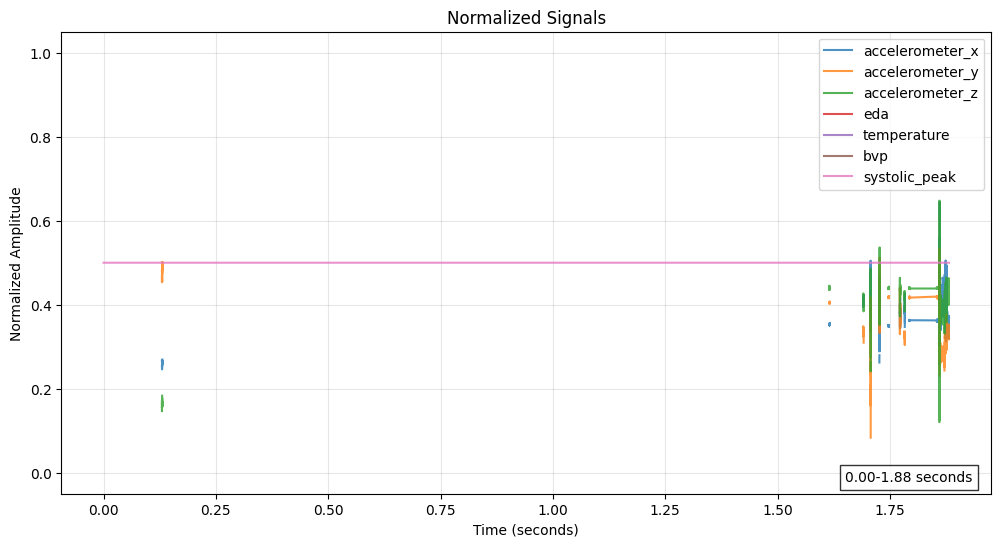

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_static_signals(signals_df, 
                        start_time=None, 
                        end_time=None,
                        normalize=False,
                        offset=True,
                        figsize=(12, 6),
                        title="Multi-Signal Visualization",
                        output_file=None,
                        show=True):
    """
    Generate a static plot of multiple signals with intelligent stacking/normalization
    
    Args:
        signals_df: DataFrame with 'timestamp' (UNIX ns) and signal columns
        start_time: Start time in UNIX ns or relative seconds (None for full range)
        end_time: End time in UNIX ns or relative seconds (None for full range)
        normalize: Normalize signals to [0,1] range (False)
        offset: Stack signals vertically with offset (True)
        figsize: Figure dimensions (12,6)
        title: Plot title
        output_file: Path to save image (None)
        show: Display plot (True)
    """
    # Create copy and convert timestamps
    df = signals_df.copy()
    df['time'] = (df['timestamp'] - df['timestamp'].min()) / 1e9  # Relative seconds
    
    # Filter time range
    if start_time is not None:
        if start_time > 1e18:  # Assume UNIX timestamp if > year 2000
            start_time = (start_time - df['timestamp'].min()) / 1e9
        df = df[df['time'] >= start_time]
    
    if end_time is not None:
        if end_time > 1e18:  # Assume UNIX timestamp
            end_time = (end_time - df['timestamp'].min()) / 1e9
        df = df[df['time'] <= end_time]

    # Get signal columns
    signal_cols = [col for col in df.columns if col not in ['timestamp', 'time']]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare signals
    if normalize:
        # Normalize to [0,1] range
        for col in signal_cols:
            min_val = df[col].min()
            max_val = df[col].max()
            df[col] = (df[col] - min_val) / (max_val - min_val) if (max_val != min_val) else 0.5
    elif offset:
        # Calculate automatic vertical offsets
        ranges = [df[col].max() - df[col].min() for col in signal_cols]
        base_offset = np.mean(ranges) * 1.2
        for i, col in enumerate(signal_cols):
            df[col] = df[col] + (i * base_offset)

    # Plot signals
    for col in signal_cols:
        ax.plot(df['time'], df[col], label=col, alpha=0.8)

    # Format plot
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Normalized Amplitude" if normalize else "Value")
    if offset and not normalize:
        ax.set_yticks([])
        ax.set_ylabel("Offset Signals")
    
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Add time range annotation
    time_range = f"{df['time'].min():.2f}-{df['time'].max():.2f} seconds"
    ax.text(0.98, 0.02, time_range, 
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(facecolor='white', alpha=0.8))

    # Output handling
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Generate sample data
    base_time = 1741801798593031  # UNIX timestamp in ns
    num_samples = 1000
    
    signals = pd.DataFrame({
        'timestamp': [base_time + i*100_000_000 for i in range(num_samples)],
        'ECG': np.random.normal(0, 1, num_samples),
        'PPG': np.random.uniform(800, 1200, num_samples),
        'GSR': np.random.exponential(1, num_samples)
    })
    
    # Plot normalized
    plot_static_signals(signals_df,
                       normalize=True,
                       offset=False,
                       title="Normalized Signals",
                       output_file="signals_normalized.png")

/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_17629/1131973784.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle


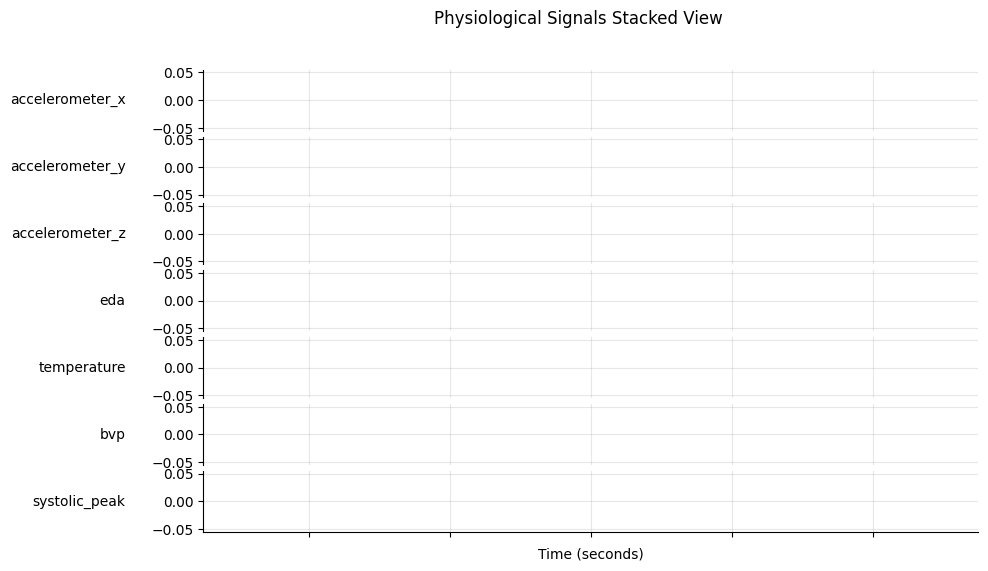

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_stacked_signals(signals_df, 
                        start_time=None, 
                        end_time=None,
                        normalize_per_channel=False,
                        figsize=(12, 8),
                        title="Multi-Signal Stacked Visualization",
                        output_file=None,
                        show=True):
    """
    Generate vertically stacked plots of multiple signals
    
    Args:
        signals_df: DataFrame with 'timestamp' (UNIX ns) and signal columns
        start_time: Start time in UNIX ns or relative seconds
        end_time: End time in UNIX ns or relative seconds
        normalize_per_channel: Normalize each signal to [0,1] range
        figsize: Figure dimensions
        title: Plot title
        output_file: Path to save image
        show: Display plot
    """
    # Process dataframe
    df = signals_df.copy()
    signal_cols = [col for col in df.columns if col != 'timestamp']
    
    # Convert timestamps to relative seconds
    min_timestamp = df['timestamp'].min()
    df['time'] = (df['timestamp'] - min_timestamp) / 1e9
    
    # Handle time range
    if start_time is not None:
        if start_time > 1e18:  # UNIX timestamp
            start_time = (start_time - min_timestamp) / 1e9
        df = df[df['time'] >= start_time]
    
    if end_time is not None:
        if end_time > 1e18:  # UNIX timestamp
            end_time = (end_time - min_timestamp) / 1e9
        df = df[df['time'] <= end_time]

    # Create subplots
    n_signals = len(signal_cols)
    fig, axs = plt.subplots(n_signals, 1, figsize=figsize, 
                           sharex=True, gridspec_kw={'hspace': 0.1})
    
    if n_signals == 1:
        axs = [axs]  # Ensure iterable
    
    # Plot each signal in its own axis
    for idx, (col, ax) in enumerate(zip(signal_cols, axs)):
        # Normalize if requested
        y = df[col].values
        if normalize_per_channel:
            y_min, y_max = y.min(), y.max()
            if y_max != y_min:
                y = (y - y_min) / (y_max - y_min)
            else:
                y = np.zeros_like(y)
        
        # Plot signal
        ax.plot(df['time'], y, color='tab:blue', linewidth=0.8)
        
        # Format axis
        ax.set_ylabel(col, rotation=0, ha='right', va='center', labelpad=40)
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(alpha=0.3)
        
        # Remove borders
        for spine in ['top', 'right', 'bottom'] if idx != n_signals-1 else ['top', 'right']:
            ax.spines[spine].set_visible(False)
        
        # Only show x-axis on bottom plot
        if idx != n_signals-1:
            ax.tick_params(axis='x', which='both', length=0)
            ax.set_xticklabels([])
    
    # Set common labels
    axs[-1].set_xlabel("Time (seconds)")
    fig.suptitle(title, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
    
    # Save/output
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    
    return fig, axs

# Example usage
if __name__ == "__main__":
    # Generate sample data
    base_time = 1741801798593031  # UNIX timestamp in ns
    num_samples = 5000
    
    plot_stacked_signals(
        signals_df,
        normalize_per_channel=True,
        figsize=(10, 6),
        title="Physiological Signals Stacked View",
        output_file="stacked_signals.png"
    )

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def visualize_async_signals(signals_dict, 
                           start_time=None, 
                           end_time=None,
                           resample_rate='1ms',
                           interpolation='nearest',
                           figsize=(16, 12),
                           output_file=None):
    """
    Visualize asynchronous signals with intelligent resampling and alignment
    
    Args:
        signals_dict: {signal_name: (timestamps_us, values)}
        start_time: Start time in microseconds (None for auto)
        end_time: End time in microseconds (None for auto)
        resample_rate: Pandas-compatible resampling frequency
        interpolation: 'linear', 'nearest', or 'none'
        figsize: Figure dimensions
        output_file: Output path for saving
    """
    # Convert all data to pandas Series
    frames = {}
    for name, (timestamps, values) in signals_dict.items():
        # Convert to nanoseconds for pandas compatibility
        index = pd.to_datetime(timestamps.astype(np.int64), unit='ns')
        frames[name] = pd.Series(values, index=index)
    
    # Create unified time index
    all_times = pd.concat([pd.Series(s.index) for s in frames.values()])
    global_start = all_times.min() if start_time is None else pd.to_datetime(start_time, unit='us')
    global_end = all_times.max() if end_time is None else pd.to_datetime(end_time, unit='us')
    
    # Create resampled index
    resampled_index = pd.date_range(start=global_start, end=global_end, freq=resample_rate)
    
    # Prepare figure
    n_signals = len(frames)
    fig, axs = plt.subplots(n_signals, 1, figsize=figsize, sharex=True)
    if n_signals == 1:
        axs = [axs]

    # Process and plot each signal
    for (name, signal), ax in zip(frames.items(), axs):
        # Resample using selected method
        if interpolation == 'none':
            resampled = signal
        else:
            resampled = signal.resample(resample_rate).interpolate(method=interpolation)
        
        # Convert time to microseconds from start
        time_us = (resampled.index - global_start).total_seconds() * 1e6
        values = resampled.values
        
        # Plot raw samples as points
        ax.plot((signal.index - global_start).total_seconds() * 1e6, 
                signal.values, 'o', markersize=2, alpha=0.5, label='Actual samples')
        
        # Plot interpolated line
        if interpolation != 'none':
            ax.plot(time_us, values, '-', linewidth=1, label=f'{interpolation} interpolation')
        
        ax.set_ylabel(name, rotation=0, ha='right', va='center')
        ax.grid(alpha=0.3)
        ax.legend()

    # Format x-axis
    axs[-1].set_xlabel('Time from start (μs)')
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate sample asynchronous data
    np.random.seed(42)
    
    # Signal 1: 60 FPS (16.666ms interval)
    t1 = np.cumsum(np.random.normal(16666, 1000, 300)).astype(np.int64)  # microseconds
    v1 = np.sin(t1/1e6 * 2*np.pi)
    
    # Signal 2: 1 FPS with jitter
    t2 = np.sort(np.random.choice(t1, 5)) + np.random.randint(-1e6, 1e6, 5)
    v2 = np.random.randn(5)
    
    # Signal 3: 30 FPS with gaps
    t3 = np.delete(t1, slice(50, 150))
    v3 = np.cos(t3/1e6 * 2*np.pi)
    
    signals = {
        '60Hz_Camera': (t1, v1),
        '1Hz_Sensor': (t2, v2),
        '30Hz_IMU': (t3, v3)
    }

    visualize_async_signals(
        signals_df,
        resample_rate='500us',  # 500 microsecond resolution
        #interpolation='linear',
        output_file='async_signals.png'
    )

ValueError: too many values to unpack (expected 2)